In [83]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
from datetime import datetime,timedelta
import calendar
import warnings

1984 extent: 3251 meters
This was calculated by measuring the length of the glacier along the centerline on a polygon of the glacier from 1958. Then extent change date from FoG_FVobs_205.csv was used to calculate the change in extent from 1958-1984

In [84]:
class glacierSim():
    def __init__(self, ela=1880,ela_1900=1650,valley_length=3668, time=500,save=10,gamma=0.01,quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5], initial_ice=None, start_time=0):
        #MODEL VARS:
        self.valley_length = valley_length
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.ela_1900=ela_1900
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        if start_time==0: self.ice = np.zeros(self.num_cells) #initialize ice
        else: self.ice = np.array(initial_ice)
        
        #PLOTTING VARS:
        self.ice_line_list=[] #stores info for plotting ice
        self.snow_line_list=[] #stores info for plotting snow
        self.ela_line_list=[] #stores info for plotting ela
        self.title_list=[] #stores info for plotting title
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.topo =[] #initialize topography
        self.quiet=quiet #set to true to printout values while model is running
        
        #ICE FLUX VARS:
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.ice_slope = np.zeros(self.num_cells, dtype=np.longdouble) #initialize ice_slope
        
        #TIME VARS:
        self.run_time=start_time*365.25 #DAYS
        self.prev_display=0 #used for displaying model data while running when quiet=false
        self.time = time #simulation time in years
        self.current_date=datetime(1484,1,1)+timedelta(days=start_time*365.25)
        self.save = save*365.25 #timestep interval in days
        self.frames = ((int)((self.time-start_time)/(self.save/365.25)))+1 #number of frames the animation will run for
        self.timestep_list=[] #days
        
        #MASS BALANCE VARS:
        self.b_max = float(-inf) #maximum yearly mass balance value for whole run
        self.b_min = float(inf) #minimum yearly mass balance valeu for whole run
        self.gamma = gamma #for mass balance equation
        self.b=np.zeros(self.num_cells) #initialize mass balance
        self.snow_depth=np.zeros(self.num_cells) #snow depth along glacier in m
        self.snow_melt_amt=np.zeros(self.num_cells) #snow melt amount in m
        self.weather_dates=[] #dates for weather data
        self.temps=[] #daily temperatures
        self.precip=[] #daily precipitation
        
        #TUNE FACTORS:
        self.ice_melt_factor=tune_factors[0] #factor to change how much the ice melts per degree C
        self.snow_melt_factor=tune_factors[1] #factor to change how much the snow melts per degree C
        # self.accum_factor=tune_factors[2] #factor to change how much snow gets turned into ice
        self.snow_conv_factor=tune_factors[5] #factor to change how much precip gets turned to snow
        # self.snow_melt_amplitude=tune_factors[4] #creates a curve to increase snow melt factor in the summer, peaks in august
        # self.ice_melt_amplitude=tune_factors[5] #creates a curve to increase ice melt factor in summer, peaks in august
        self.temp_lapse_rate=tune_factors[2] #temp lapse rate in C/m]
        self.accumfactor_lower=tune_factors[3] #lower bound to change how much snow gets turned into ice
        self.accumfactor_upper=tune_factors[4] #upper bound to change how much snow gets turned into ice
        
        #VERIF VARS:
        self.annual_mb=[] #annual mass balance verif data
        self.winter_mb=[] #winter (positive) mass balance verif data
        self.summer_mb=[] #summer (negative) mass balance verif data
        self.thickness_change_verif=np.zeros(4) #thickness change for verif
        self.front_variation_verif=np.zeros(100) #front variation verification data
        self.ela_verif=np.zeros(100) #ela's for verification
        self.runoff_verif_2002_2003=[] #holds volume validation data
        self.runoff_verif_2005_2006=[] #holds volume validation data
        self.thickness_1986_verif=0 #thickness in 1986 for verif
        self.thickness_2021_verif=0 #thickness in 2021 for verif
        self.date_index_2002_2003=np.zeros(100) #stores dates used for vol change verif
        self.date_index_2005_2006=np.zeros(100) #stores dates used for vol change verif
        
        #CALCULATED VERIF VARS:
        self.volume_by_year=np.zeros(41) #volume change of glacier per year
        self.daily_volume_change=np.zeros(180) #tracks daily volume change of glacier, eventually summed up for monthly volume change
        self.calculated_annual_mb=np.zeros(40, dtype=np.float64) #used to verify annual mass balance
        self.calculated_winter_mb=np.zeros(40, dtype=np.float64) #used to verify winter (positive) mass balance
        self.calculated_summer_mb=np.zeros(40, dtype=np.float64) #used to verify summer (negative) mass balance
        self.front_variation_calc=np.zeros(100) #model calculated front variation
        self.thickness_change=np.zeros(4) #model thickness change
        self.year_mb=np.zeros(len(self.b)) #keeps track of the mb for the current year to calculate ela line
        self.ice_1986=np.zeros(self.num_cells) #stores the ice in 1986
        self.volume_change=[] #tracks the volume change of glacier
        self.ice_volume=0 #volume of glacier in m^3
        self.glacial_melt=0
        self.snow_melt_vol=0 #volume of melted snow in m^3, used to factor in snowmelt to volume calculations for stream flow data comparisons
        self.glacier_extent=0 #length of glacier in m
        self.ela_list=[] #list of ela values over time, used for verif
        self.ice_thickness_over_time=[] #tracks avg ice thickness over time
        self.daily_runoff_2002_2003=[] #holds daily runoff data for 2002-2003
        self.daily_runoff_2005_2006=[] #holds daily runoff data for 2005-2006
        
        #PREV VARS:
        self.prev_thickness=np.mean(self.ice) #previous avg ice thickness used to calculate thickness change
        self.prev_front=np.max(self.x[self.ice>1]) if np.any(self.ice>1) else 0 #previous front location to calculate front var change
        self.prev_volume=0 #previous glacier volume for calculating volume change
        self.initial_volume=0 #initial glacier volume for calculating volume change
        
        #WIDTH VARS:
        self.bins=[] #elevation bins for widths
        self.years=[] #years for width data
        self.areas=[] #area of glacier in m^2, used to calculate width
        self.widths=np.zeros(self.num_cells) #keeps track of glacier widths
        self.widths_over_time=[]  #used to plot width change over time
        self.year_area=np.zeros(self.num_cells)
        self.glacier_area=0
        self.year_area_list=[]
        self.area_list=[]
        
    def init(self, ax,ela=1880,ela_1900=1650,valley_length=3668, time=500,save=10,gamma=0.008, quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5], initial_ice=None, start_time=0):
        self.__init__(ela, ela_1900,valley_length, time, save, gamma, quiet, tune_factors, initial_ice, start_time)
        self.load_verif_data()
        self.calc_topo()
        self.calc_widths()
        self.load_mb_data()
        try: curr_ela=self.topo[np.where((self.b[:-1] >= 0) & (self.b[1:] < 0))[0]][0]
        except: curr_ela=self.topo[-1]
        self.ela_list.append(curr_ela)

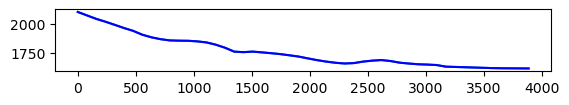

In [85]:

class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        latitudes = []
        longitudes = []
        topo = []
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/centerlineBed.csv')
        latitudes = df.iloc[:, 2].astype(float).tolist()  # Latitude is the second column (index 2)
        longitudes = df.iloc[:, 1].astype(float).tolist()  # Longitude is the third column (index 1)
        topo = df.iloc[:, 0].astype(float).tolist()  # Elevation is the first column (index 0)
        cumulative_distances=[0.0]
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells) #creates self.x values
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, topo) #interpolates bed topo to get elevations at self.x values
        self.valley_length=np.max(self.x)
        self.dx = self.valley_length/(self.num_cells-1) #re-initializes dx using updates valley length
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx)) #initial ice slope is just topo slope
        #THIS CREATES A FAKE INITIAL ICE FOR ICE FLUX TESTING
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        #INITIALIZE VOLUME VARIABLES
        # self.ice_volume=np.sum(self.ice*self.widths*self.dx)
        self.ice_volume=np.mean(self.ice)*self.year_area
        self.initial_volume=self.ice_volume
        self.prev_volume=self.ice_volume.copy()
        self.volume_change.append(self.initial_volume)
        df= pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/centerlineThickness_1986.csv')
        self.thickness_1986_verif=df.iloc[0:, 3].astype(float).to_numpy()-df.iloc[0:, 0].astype(float).to_numpy()
        df= pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/centerlineThickness_2021.csv')
        self.thickness_2021_verif=df.iloc[0:, 3].astype(float).to_numpy()-df.iloc[0:, 0].astype(float).to_numpy()
        self.thickness_1986_verif=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_1986_verif) if type(self.thickness_1986_verif) is not int else np.zeros(self.num_cells)
        self.thickness_2021_verif=np.maximum(np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_2021_verif) if type(self.thickness_2021_verif) is not int else np.zeros(self.num_cells),0)
        
    def calc_widths(self):
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Input_SouthCascade_Area_Altitude_Distribution.csv')
        self.bins = df.columns[2:].astype(float).to_numpy()
        self.years = df.iloc[:, 0].astype(float).tolist()
        self.areas = df.iloc[:, 2:].astype(float).values*1000000
        self.bin_bounds=np.concatenate(([self.bins[0] - 25], (self.bins[:-1] + self.bins[1:]) / 2, [self.bins[-1] + 25]))
        area=self.areas[0,:]
        bin_indices = np.digitize((self.topo+self.ice), self.bins)
        for i in range(len(area)):
            mask = (bin_indices == i)
            cell_indices = np.where(mask)[0]
            n_cells = len(cell_indices)
            if n_cells > 0:
                base_area = area[i] / n_cells
                self.year_area[mask] = base_area
                self.year_area[cell_indices[0]] += (area[i] - (base_area * n_cells))
        if np.sum(self.year_area)<np.sum(area): self.year_area+=(np.sum(area)-np.sum(self.year_area))/len(self.year_area)
        if round(np.sum(self.year_area))!=round(np.sum(area)):
            print("Warning: Year area does not equal area")
            print("Year area: ", round(np.sum(self.year_area)))
            print("Area: ", round(np.sum(area)))
            print("Difference: ", round(np.sum(self.year_area)-np.sum(area)))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.widths = np.array(self.areas[0,:]/np.abs(np.diff(self.x[np.array([np.argmin(np.abs(self.topo+self.ice - bin_value)) for bin_value in self.bin_bounds])])))[np.searchsorted(self.bin_bounds, (self.topo+self.ice))]
        self.widths[np.isinf(self.widths)]=0 #Due to the way widths are calculated, if the width is infinite it really should be 0
                
    def update_widths(self):
        prev_width=self.widths
        area=self.areas[(self.current_date.year-1950),:]
        bin_indices = np.digitize((self.topo+self.ice), self.bins)
        for i in range(len(area)):
            mask = (bin_indices == i)
            cell_indices = np.where(mask)[0]
            n_cells = len(cell_indices)
            if n_cells > 0:
                base_area = area[i] / n_cells
                self.year_area[mask] = base_area
                self.year_area[cell_indices[0]] += (area[i] - (base_area * n_cells))
        if np.sum(self.year_area)<np.sum(area): self.year_area+=(np.sum(area)-np.sum(self.year_area))/len(self.year_area)
        if round(np.sum(self.year_area))!=round(np.sum(area)):
            print("Warning: Year area does not equal area")
            print("Year area: ", round(np.sum(self.year_area)))
            print("Area: ", round(np.sum(area)))
            print("Difference: ", round(np.sum(self.year_area)-np.sum(area)))
        #Re-calculates widths
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.widths = np.array(self.areas[(self.current_date.year-1950),:]/np.abs(np.diff(self.x[np.array([np.argmin(np.abs(self.topo+self.ice - bin_value)) for bin_value in self.bin_bounds])])))[np.clip((np.searchsorted(self.bin_bounds, (self.topo+self.ice))),0,(len(self.areas[0])-1))]
        self.widths[np.isinf(self.widths)]=0
        if np.abs(self.widths-prev_width).any()>0:
            if self.current_date.year==2021: 
                area=self.areas[(self.current_date.year-1950),:]
            self.widths_over_time.append(self.widths.copy())
            self.ice_thickness_over_time.append(self.ice.copy())
        
glac=glacierSim()
glac.calc_topo()
glac.calc_widths()
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [86]:
class glacierSim(glacierSim):
    def load_mb_data(self):
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Input_SouthCascade_Daily_Weather.csv')
        self.dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
        self.temps = df.iloc[:, 1].astype(float).to_numpy()
        self.precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
        #MAKE NOTE OF THIS IN THESIS, SOME OF THE TEMPERATURE DATA IS INTERPOLATED BECAUSE ITS MISSING
        nan_indices = np.isnan(self.temps)
        x = np.arange(len(self.temps))
        self.temps[nan_indices] = np.interp(x[nan_indices], x[~nan_indices], self.temps[~nan_indices])

    def load_verif_data(self):
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', skiprows=25)
        self.annual_mb = df.iloc[:-1, 3].astype(float).tolist()
        self.summer_mb = df.iloc[:-1, 2].astype(float).tolist()
        self.winter_mb = df.iloc[:-1, 1].astype(float).tolist()
        self.ela_verif=df.iloc[5:, 4].astype(float).to_numpy()
        self.calculated_annual_mb=np.array([0] * len(self.annual_mb), dtype=np.float64)
        self.calculated_winter_mb=np.array([0] * len(self.winter_mb), dtype=np.float64)
        self.calculated_summer_mb=np.array([0] * len(self.summer_mb), dtype=np.float64)
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/daily_average_runoff_with_dates.csv')
        df['date'] = pd.to_datetime(df['date'])
        self.runoff_verif_2002_2003 = df.groupby(df['date'].dt.to_period('M'))['runoff'].sum().to_numpy()
        self.date_index_2002_2003 = {date: idx for idx, date in enumerate(df['date'])}
        self.daily_runoff_2002_2003=np.zeros(len(self.date_index_2002_2003))
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Daily_Runoff_Data_2005-2006_.csv')
        df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
        self.runoff_verif_2005_2006 = df.groupby(df['date'].dt.to_period('M'))['runoff'].sum().to_numpy()
        self.date_index_2005_2006 = {date: idx for idx, date in enumerate(df['date'])}
        self.daily_runoff_2005_2006=np.zeros(len(self.date_index_2005_2006))
        self.thickness_change_verif = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/thickness_change.csv').iloc[0:, 11].astype(float).to_numpy()
        self.front_variation_verif = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/front_variation_change.csv').iloc[0:, 9].astype(float).to_numpy()
        self.front_variation_calc = np.zeros(len(self.front_variation_verif))
        df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/middle_tarn_basin_minus_glacier_elev_areas.csv')
        self.snow_areas=df.iloc[0:, 0].astype(float).to_numpy()
        self.snow_elev_bins=np.round((np.convolve(np.append(df.iloc[0:,1].astype(float).to_numpy(),2475),[1,1],'valid')/2),0)
        self.snow_depth=np.zeros(len(self.snow_areas))
        self.snow_melt_amt=np.zeros(len(self.snow_areas))
        
    def calc_verif(self,timestep):
        #Round current date since all of the lists are based on day or year
        current_date_key = self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)
        #These are the days before the start dates for the volume verif data so need to set the pre_volume to calculate volume change
        if current_date_key==datetime(2002,9,30) or  current_date_key==datetime(2003,6,8): self.prev_volume=self.ice_volume.copy()
        #If date is in the list of volume verification dates, calculate the volume change
        if current_date_key in self.date_index_2002_2003:
            # self.daily_runoff_2002_2003[self.date_index[current_date_key]] += (self.prev_volume-self.ice_volume+self.snow_melt_vol)
            self.daily_runoff_2002_2003[self.date_index_2002_2003[current_date_key]] += (self.glacial_melt+self.snow_melt_vol)
            self.prev_volume=self.ice_volume.copy()
        if current_date_key in self.date_index_2005_2006:
            self.daily_runoff_2005_2006[self.date_index_2005_2006[current_date_key]] += (self.glacial_melt+self.snow_melt_vol)
        #If date is the date before thickness change verification data starts then set prev_thickness to calculate thickness change
        if self.current_date==datetime(1998,12,31): self.prev_thickness=np.mean(self.ice)
        #Calculate thickness change data
        if 1999 <= self.current_date.year < 2004:
            avg_thickness=np.mean(self.ice)
            self.thickness_change[0]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2004 <= self.current_date.year < 2009: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[1]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2009 <= self.current_date.year < 2014: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[2]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        if 2014 <= self.current_date.year < 2019: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[3]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        #If date is the date before front variation change verification data starts then set prev_front to calculate front variation change
        if self.current_date==datetime(1983,12,31): self.prev_front=np.max(self.x[self.ice > 1])
        #Calculate front variation data
        if 1984<=self.current_date.year<2009:
            if np.any(self.ice>1):
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-np.max(self.x[self.ice > 1])
                self.prev_front=np.max(self.x[self.ice > 1])
            else:
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-self.x[0]
                self.prev_front=self.x[0]
        #Calcualte ice thickness data for 1986
        if self.current_date.year==1986: self.ice_1986=self.ice[~np.isnan(self.thickness_1986_verif)].copy()
        #This will end up setting the yearly volume to the volume at the end of the year
        if self.current_date.year>=1984: self.volume_by_year[self.current_date.year-1984]=self.ice_volume
        #Add mass balance to verification arrays
        if 1984<=self.current_date.year<2024:
            date=int(self.current_date.year-1984)
            self.calculated_annual_mb[date]+=np.mean(np.array(self.b*timestep)) if self.b.size>0 else 0
            self.calculated_winter_mb[date]+=np.mean(np.array(self.b[self.b>0]*timestep)) if self.b[self.b>0].size>0 else 0
            self.calculated_summer_mb[date]+=np.mean(np.array(self.b[self.b<0]*timestep)) if self.b[self.b<0].size>0 else 0
        #Make sure mass balance verification arrays are correct
        if np.any(self.calculated_winter_mb<0): print("ERROR IN WINTER MB")
        if np.any(self.calculated_summer_mb>0): print("ERROR IN SUMMER MB")
    
    # def snow_model(self, index, temps,timestep):
    #     #If temp is less than 0 precip falls as snow, so add it to snow depth
    #     #Note: This might need to be changed because if temp is just below 0, the snow_conv_factor will be wildly different then if the temp is way below 0
    #     new_snow=(self.precip[index]/1000)*self.snow_conv_factor*timestep
    #     self.snow_depth[temps<0]+=new_snow
    #     if np.any(new_snow<0):print("NEGATIVE NEW SNOW")
    #     #Calculates the amount of snow to melt in m based on temp and snow_melt_factor, value is always negative since temp is always negative
    #     snow_melt=(self.snow_melt_factor*temps[temps>0] if int(self.current_date.month) in [12,1,2] else (self.snow_melt_amplitude/2*(1-math.cos(2*math.pi/8*((self.current_date.month+(self.current_date.day+1)/calendar.monthrange(self.current_date.year, self.current_date.month)[1])-11))) + self.snow_melt_factor)*temps[temps>0])*timestep
    #     snow_melt_diff=(snow_melt * -1) - self.snow_depth[temps > 0] #Difference between the amount of snow to melt and the current snow depth
    #     snow_melt[snow_melt_diff>0] = self.snow_depth[temps>0][snow_melt_diff>0]*-1 #Janky way of setting the maximum snow melt to the snow depth
    #     if np.any(snow_melt>0): print("POSITIVE SNOW MELT")
    #     #Calculates the volume of melted snow
    #     #Note: Need to change width to valley width instead of glacier width
    #     self.snow_melt_vol=np.sum(snow_melt*self.dx*self.widths[temps>0])
    #     self.snow_depth[temps>0]+=snow_melt
    
    def snow_model(self, index,timestep):
        snow_temps=self.temps[index]-self.temp_lapse_rate*(self.snow_elev_bins-272)
        self.snow_depth[snow_temps<0]+=(self.precip[index]/1000)*self.snow_conv_factor*timestep
        self.snow_melt_amt.fill(0)
        self.snow_melt_amt[snow_temps>0]=self.snow_melt_factor*self.snow_depth[snow_temps>0]*timestep
        self.snow_depth[snow_temps>0]+=self.snow_melt_amt[snow_temps>0]
        self.snow_melt_vol=np.sum(self.snow_melt_amt*-1*self.snow_areas)

    def update_b(self, timestep):
        if self.current_date>=datetime(1984,1,2):
            #Calculate which index to get weather data from
            if self.current_date<datetime(2024,10,1): index=self.dates.index(pd.Timestamp(self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)))
            else: index=self.dates.index(pd.Timestamp(datetime(2024, 9, 30)))
            #Calculates temperatures for every self.x value and varies temp with elevation
            x_temps=self.temps[index]-self.temp_lapse_rate*(self.ice+self.topo-272) #weather station elevation is 272m
            mb=np.zeros_like(x_temps) #initialize mass balance
            #Melts ice for temps greater than 0
            melt_arr=self.snow_melt_factor+((self.curr_ela-(self.ice+self.topo))/(self.curr_ela-np.nanmin(self.topo+self.ice)))*(self.ice_melt_factor-self.snow_melt_factor)
            melt_arr[melt_arr>self.snow_melt_factor]=self.snow_melt_factor
            mb[np.where((x_temps>0)&((self.ice+self.topo)>=self.curr_ela))[0]]=self.snow_melt_factor*x_temps[np.where((x_temps>0)&((self.ice+self.topo)>self.curr_ela))[0]]
            mb[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]=melt_arr[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]*x_temps[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]
            self.glacial_melt=np.sum(mb[mb<0]*self.year_area[mb<0])*timestep
            #mb[x_temps>0]= self.ice_melt_factor*x_temps[x_temps>0] if int(self.current_date.month) in [12,1,2] else (self.ice_melt_amplitude/2*(1-math.cos(2*math.pi/8*((self.current_date.month+(self.current_date.day+1)/calendar.monthrange(self.current_date.year, self.current_date.month)[1])-11))) + self.ice_melt_factor)*x_temps[x_temps>0]
            #Calculates snow melt and accumulation
            self.snow_model(index,timestep)
            #Can't melt ice where there is snow
            #mb[(x_temps>0)&(self.snow_depth>0.1)]=0
            #Where temps are less than 0, accumulate ice based on snow depth
            #Note: Should this be changed to not factor in temps? Will snow accumulate to ice if the temp is above 0?
            # mb[x_temps<0]=self.snow_depth[x_temps<0]*self.accum_factor
            #IDEA: Try multiplying the accum_factor by elevation to change accumulation along glacier
            accumfactor = self.accumfactor_lower + ((self.current_date.year - 1984) / (2024 - 1984)) * (self.accumfactor_upper - self.accumfactor_lower)
            mb[x_temps<0]=(self.precip[index]/1000)*accumfactor
            #Subtract snow that was just turned into ice
            # subtract_snow = (self.snow_depth[x_temps<0]*self.accum_factor*timestep)
            # Check if any of the potential new values are negative
            # if np.any(subtract_snow > self.snow_depth[x_temps < 0]): print("THERE WILL BE NEGATIVE SNOW DEPTH")
            # self.snow_depth[x_temps<0]-=subtract_snow
            #Double check for accidental negative snow depth
            # if np.any(mb==0):
            #     print(self.current_date)
            #     print(x_temps)
            #     print(self.precip[index])
            #     print(mb)
            # if np.any(self.snow_depth[x_temps<0]<0): print("NEGATIVE SNOW DEPTH, NEGATIVE TEMP")
            # if np.any(self.snow_depth[x_temps>0]<0): print("NEGATIVE SNOW DEPTH, POSITIVE TEMP")
            #Make sure there is no negative snow, everything before this should make this impossible
            # self.snow_depth=np.maximum(self.snow_depth,0)
            #Alert for weird mass balance values
            if np.any(mb[x_temps<0]<0): print("NEGATIVE MB", mb[x_temps<0])
            if np.any(np.isnan(mb[x_temps < 0])): print("NAN MB", self.precip[index])
            if np.any(np.abs(mb)>100): print("MB TOO BIG",mb)
            return mb
        else: 
            #Used to spin up the glacier. Glacier starts retreating in 1900
            return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25 #meters per day
            #return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25

In [87]:
class glacierSim(glacierSim):
    def calc_q(self):
        #Calculate ice clops
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx)
        #Check for weird ice and ice_slope values
        if np.any(np.isnan(self.ice_slope)): #and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("TIME: ", self.run_time)
            plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)): #and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)): # and not self.quiet:
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.run_time)
            plt.plot(self.timestep_list)
            return
        #Calculate ice flux
        #self.q[1:] = (0.2 *(2e-17*2) * (self.p * self.g)**2) * np.sin(np.arctan(self.ice_slope))**2 * (self.ice**5)/5
        #self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #YEARS
        self.q[1:]=5.87e-19* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #DAYS
        #Check for weird q values
        if np.any(np.isnan(self.q)): #and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        #Print model status every self.save years if quiet is false
        if (self.prev_display==0.0 or ((self.run_time>=(self.prev_display+(self.save/365.25))*365.25) and self.run_time<(self.time*365.25))) and not self.quiet:
            print("TIME: ", math.floor(self.run_time/365.25))
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("ICE VOLUME: ",self.ice_volume/1e9, " km^3")
            print("Difference from inital volume: ", self.ice_volume/1e9-self.initial_volume/1e9, " km^3")
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.run_time/365.25
        #Calculate the change in ice thickness and return it
        return (self.b-(np.diff(self.q)/self.dx)) 

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 2]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        #print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        # if(self.default_b):
        #     print('B min: ' + str(self.b_min))
        #     print('B max: ' + str(self.b_max))

    def run_model(self,i):
        #Used to plot initial values
        if i==0:
            curr_ela_plt=[self.start_ela]*self.num_cells
            self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
            # self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
            self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
            self.title_list.append('Year = ' + str(self.current_date.year))
            return
        iter_time=0.0 #days
        timestep=0.0 #days
        while(iter_time<self.save):
            #End while loop if the difference between the save and current iter_time is less than 1, this is done to make sure it doesn't run over
            if (self.save-iter_time)<1: break
            #Calculate glacier velocity for timestep calculation
            u = (5.87e-19)*((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*(((self.ice)**4)/5)
            #Calculate the timestep based on glacier velocity, the 0.2 multiplier can be changed, increase it to increase the timestep
            #Timestep is constrained between 0.0001 and 1 and rouned to the 5th decimal place, its always 1 though
            timestep = round(np.clip(((self.dx / np.nanmax(u)) * 0.2), 0.0001, 1),4) if np.any(u > 0) else 1
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            dqdx=self.calc_q()
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            # self.ice_volume=np.sum(self.ice*self.dx*self.widths)
            self.ice_volume=np.sum(np.mean(self.ice)*self.year_area)
            #Update time variables
            iter_time+=float(timestep)
            self.run_time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update width if width data is available for the current date, updates on the 1st of the year
            if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_widths()
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
        #If this if-statement runs somehow the model ran over which is a problem. The first if statement in the while loop should prevent this
        if(iter_time>self.save):
            print("BROKEN ABORT ABORT", iter_time,self.save)
            return
        #Calculate last ice_flux for this run
        dqdx=self.calc_q()
        #This if statement is also to make sure it doesn't run over. Since self.save should never be a fraction of a year then the current run should always end on 12/31
        if(self.current_date.day!=1):
            #Calculate the timestep so that it doesn't go over
            if(self.current_date.day==31): timestep=float((datetime((self.current_date.year+1),1,1)-self.current_date).total_seconds()/ (24 * 3600))
            else: timestep=float(self.save-iter_time)
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            # self.ice_volume=np.sum(self.ice*self.dx*self.widths)
            self.ice_volume=np.sum(np.mean(self.ice)*self.year_area)
            #Update time variables
            iter_time+=float(timestep)
            self.run_time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update width if width data is available for the current date, updates on the 1st of the year
            if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_widths()
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
        #If the weather data is being used for the mass balance then calculate ela
        if self.current_date.year>=1984:
            #The try-except block is there incase the yearly mass balance is all positive or all negative
            try: curr_ela=float(self.topo[np.where((self.year_mb[:-1] >= 0) & (self.year_mb[1:] < 0))[0][0]])
            except:
                #If the try-except block fails then set ela to the top or bottom of the glacier depending on if the mass balance is all positive or all negative
                if np.all(self.year_mb>0): curr_ela=float(self.topo[0])
                else: curr_ela=float(self.topo[-1])
            #Add to ela list after 1989 because that's when ela verification data starts
            if self.current_date.year>1989: self.ela_list.append(curr_ela)
            #Reset year_mb to 0 for the next year
            self.year_mb.fill(0)
        #Otherwise set ela to the start ela
        else: curr_ela=self.curr_ela
        #Make sure to reset year_mb to 0 on the first of the year
        if self.current_date.month==1 and self.current_date.day==1: self.year_mb.fill(0)
        curr_ela_plt=[curr_ela]*self.num_cells
        #If the current date is the end date then report final values
        if(self.current_date.year==1484+self.time): self.report_final_values(u)
        #Update width if width data is available for the current date, updates on the 1st of the year
        if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_widths()
        #Add data to plotting lists
        self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
        # self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
        self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
        self.title_list.append('Year = ' + str(self.current_date.year))

    #Used to plot the model data after the model has run
    def func(self,i):
        ax.clear() # Remove this to make lines stack up
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, float(self.valley_length))
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        ax.set_title(self.title_list[i])
        self.ela_line=ax.plot(self.ela_line_list[i][0],self.ela_line_list[i][1], color=self.ela_line_list[i][2], linestyle=self.ela_line_list[i][3], label=self.ela_line_list[i][4])
        self.ice_line=ax.plot(self.ice_line_list[i][0],self.ice_line_list[i][1], color=self.ice_line_list[i][2], label=self.ice_line_list[i][3])
        # self.snow_line=ax.plot(self.snow_line_list[i][0],self.snow_line_list[i][1], color=self.snow_line_list[i][2], label=self.snow_line_list[i][3])
        ax.legend()
        return self.ice_line_list,self.ela_line_list
    

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

In [ ]:
ela=1880
ela_1900=1930
time=540
start_time=500
save=1 #Needs to be 1 for the ela_list to work properly
gamma=0.016
quiet=True
# accumfactor=0.004731588686211069*1.2
# ice_meltfactor=-0.008472259912843966
# snow_meltfactor= -0.0036515609274413875
# snow_conv_factor=  5.310488160176582*1.2
# snow_melt_amplitude= -0.005747189439663826
# ice_melt_amplitude=  -0.002254212082875086
#Note: One of the papers I found had snow_meltfactor around 0.004 and ice_meltfactor around 0.006. 
# This is in meters water equivalent per positive degree day, NOT PER DEGREE C
# accumfactor=0.0319 #bounds approx 0.001-0.005
# accumfactor=1.7
accumfactor_lower=1.31
accumfactor_upper=1.97
#-0.0035 for both minimizes summer mb diff
ice_meltfactor= -0.0035 #bounds approx 0.005-0.012
snow_meltfactor=-0.0035 #bounds approx 0.002-0.006
snow_conv_factor=8.97#bounds 5-15
lapse_rate=0.0065
tune_factors=[ice_meltfactor,snow_meltfactor,lapse_rate,accumfactor_lower,accumfactor_upper,snow_conv_factor]
#tune_factors=[-6.21530477e-03, -3.16373793e-03,  3.90806503e-03,  6.37238199e+00,-5.37087541e-03,-1.14816075e-03]
# tune_factors=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude,lapse_rate]
#tune_factors=[-7.94739209e-03 ,-8.02449065e-03 , 1.04047812e-02,  9.01413327e+00,-7.81444522e-04, -9.97332457e-04]
ice = [ 53.89550985, 61.2302675, 68.52805603, 72.16752233, 78.19477103,
86.57434438, 94.52278703, 113.00567764, 124.65045342, 131.1336047,
132.61805723, 126.05975829, 117.01403765, 110.72201024, 107.36448442,
113.23158091, 127.19316445, 150.80920841, 147.75800077, 135.19461921,
132.62404257, 130.58089845, 128.95030221, 129.67226275, 131.1275745,
137.76555425, 144.54125286, 149.5876901, 152.88274456, 152.52189309,
142.71479768, 122.66643947, 105.65745331, 89.73132543, 84.64598526,
84.39967405, 78.27781775, 70.24575207, 57.81117783, 43.58883439,
34.64893057, 15.29705107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
plt.rcParams['animation.embed_limit'] = 40
def frame_generator(): 
  for i in range(0,model.frames): yield i
model = glacierSim(ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
model.init(ax,ela=ela, ela_1900=ela_1900,time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
for i in range(0,model.frames):
  model.run_model(i)
# anim = FuncAnimation(fig, model.func, frames=frame_generator, blit=False, repeat=False, save_count=model.frames)
# vid = HTML(anim.to_jshtml())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_2002_2003.keys())),'volume_change': model.daily_runoff_2002_2003})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change = df.groupby('date')['volume_change'].sum().to_numpy()
print("Final Year: ", model.current_date.year)
print("ICE: ",model.ice)
#print("SLOPE: ",model.ice_slope)
#print("MASS BALANCE: ",model.b)
print("WINTER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_winter_mb-model.winter_mb)/model.winter_mb*100))
print("SUMMER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_summer_mb-model.summer_mb)/model.summer_mb*100))
#print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
#print('ANNUAL MB DIFF: ',np.array(model.calculated_annual_mb)-np.array(model.annual_mb))
# print("VOLUME DIFF: ", np.sum(model.daily_volume_change-model.volume_valid))
print("VOL:", np.sum((monthly_volume_change- model.runoff_verif_2002_2003) / (model.runoff_verif_2002_2003)* 100))
print("THICK: ", np.sum((model.thickness_change-model.thickness_change_verif) /np.abs(model.thickness_change_verif) * 100))
print("FRONT VAR: ", np.sum((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100))
print("ELA: ",np.sum((model.ela_list-model.ela_verif)/np.abs(model.ela_verif)*100))
print("DONE")
# plt.plot(model.yearly_volume_change)
# plt.show()
# plt.plot(abs(model.volume_valid-model.daily_volume_change)/abs(model.volume_valid)*100)
# plt.show()
# vid

Final glacier length: 3093.8274768435194m
Final max ice thickness: 123.91794987792701m
Final Year:  2024
ICE:  [ 33.15045967  37.80215847  42.38680079  43.71310169  46.8463237
  52.16980787  57.59131039  74.0081367   85.40020126  92.26433068
  94.40200337  88.60011232  80.14115121  74.05536521  70.3984054
  75.35014473  88.78696914 112.67843414 110.54556656  98.87746564
  96.97423589  95.56554475  94.54298445  95.84829968  97.93027692
 105.25393264 112.87811333 118.8873692  123.20998313 123.91794988
 115.2122125   96.29553224  80.37139679  65.34615724  60.58665905
  60.39618411  54.41068598  46.07262476  32.41016601  13.9263796
   1.0005294    0.99920303   0.99897865   0.99875426   0.99852987
   0.99830548   0.99817367   0.99812219   0.99807071   0.99801923]
WINTER MB RELATIVE ERROR:  647.6356695268252
SUMMER MB RELATIVE ERROR:  -405.2902687676335
VOL: 7.047789211251467
THICK:  -199.74827419081322
FRONT VAR:  26407.659002786226
ELA:  -420.82339604383066
DONE


2021 Extent:  2617.8540188675934
2021 Max Ice Thickness:  151.2417176784229


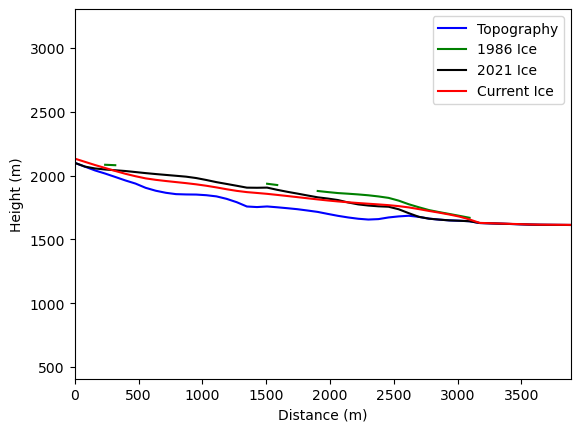

In [89]:
fig, ax = plt.subplots() #initialize plotting variables
print("2021 Extent: ",np.nanmax(model.x[model.thickness_2021_verif > 2]))
print("2021 Max Ice Thickness: ",np.nanmax(model.thickness_2021_verif))
ax.set_ylim(min(model.topo) - 100, max(model.topo) + 100)
ax.set_xlim(0, float(model.valley_length))
ax.set_ylabel("Height (m)")
ax.set_xlabel("Distance (m)")
ax.set_aspect('equal', adjustable='datalim')
ax.plot(model.x, model.topo, color="b", label="Topography")
ax.plot(model.x,model.thickness_1986_verif+model.topo, color="g", label="1986 Ice")
ax.plot(model.x,model.thickness_2021_verif+model.topo, color="black", label="2021 Ice")
ax.plot(model.x, model.ice+model.topo, color="r", label="Current Ice")
ax.legend()
plt.show()

2015 extent is 2114

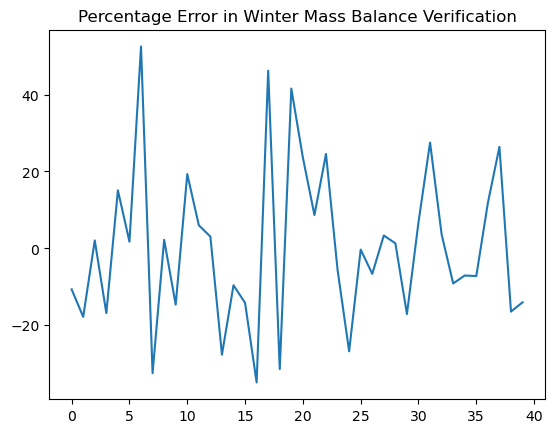

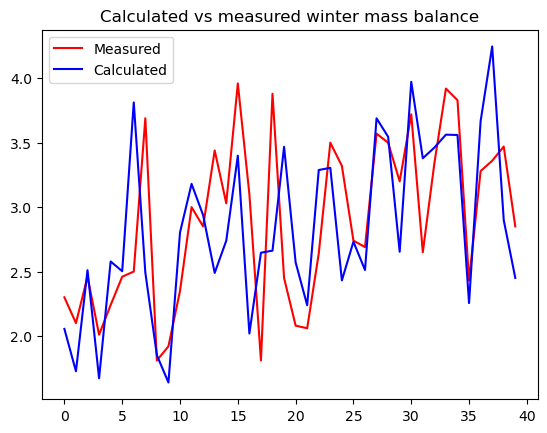

7.232254180664562
Measured:  [2.3, 2.1, 2.46, 2.01, 2.24, 2.46, 2.5, 3.69, 1.81, 1.92, 2.35, 3.0, 2.85, 3.44, 3.03, 3.96, 3.1, 1.81, 3.88, 2.45, 2.08, 2.06, 2.64, 3.5, 3.32, 2.74, 2.69, 3.57, 3.5, 3.2, 3.72, 2.65, 3.34, 3.92, 3.83, 2.43, 3.28, 3.36, 3.47, 2.85]
Calculated:  [2.05478    1.72605675 2.5107345  1.67165619 2.578066   2.50285381
 3.81253775 2.492434   1.850256   1.63909719 2.80387787 3.1805175
 2.93728275 2.48914612 2.739594   3.39915225 2.019003   2.64613894
 2.66242238 3.46803981 2.5712585  2.2387475  3.28811138 3.30493556
 2.4314285  2.73160587 2.51191838 3.68945875 3.54620075 2.65372631
 3.9726285  3.379145   3.462018   3.56255625 3.559705   2.25517625
 3.66725575 4.24680019 2.89942075 2.4502305 ]


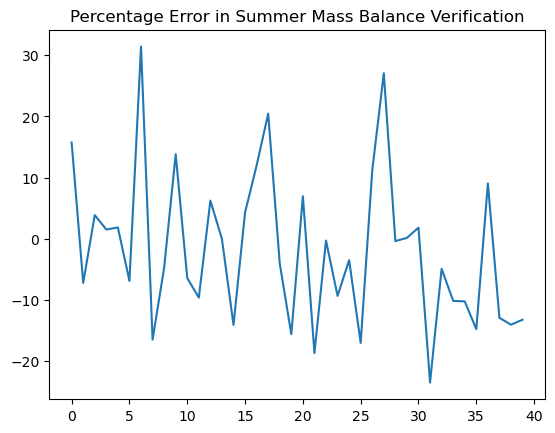

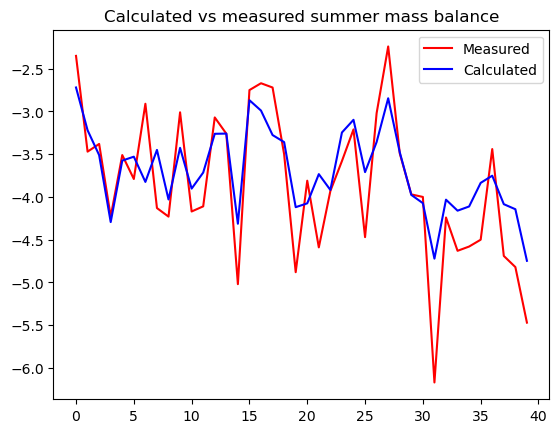

-70.62552485679402
[-2.35, -3.47, -3.38, -4.23, -3.51, -3.79, -2.91, -4.13, -4.23, -3.01, -4.17, -4.11, -3.07, -3.26, -5.02, -2.75, -2.67, -2.72, -3.5, -4.88, -3.81, -4.59, -3.93, -3.58, -3.21, -4.47, -3.02, -2.24, -3.49, -3.97, -4.0, -6.17, -4.24, -4.63, -4.58, -4.5, -3.44, -4.69, -4.82, -5.47]
[-2.71963858 -3.219931   -3.51058985 -4.29419661 -3.57473086 -3.52898042
 -3.82417845 -3.44991045 -4.02933395 -3.42575745 -3.90240361 -3.71482251
 -3.26132573 -3.25890519 -4.31321526 -2.86850812 -2.98987256 -3.27605479
 -3.35831957 -4.11957613 -4.07482316 -3.73309944 -3.91836685 -3.24602551
 -3.09770294 -3.70950119 -3.35736293 -2.84582358 -3.47666134 -3.97585537
 -4.0726624  -4.72159874 -4.03186662 -4.16051969 -4.11136875 -3.83529178
 -3.75144558 -4.08450554 -4.14360514 -4.7468957 ]


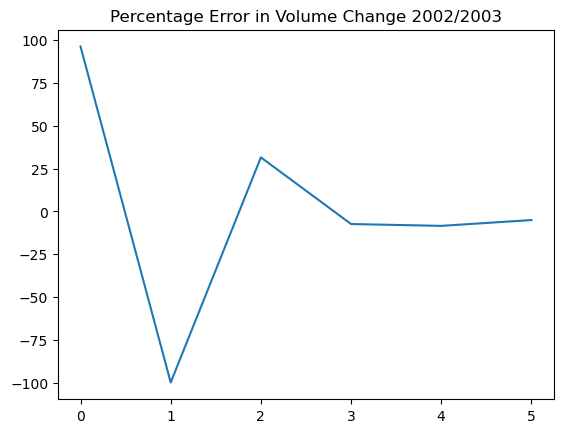

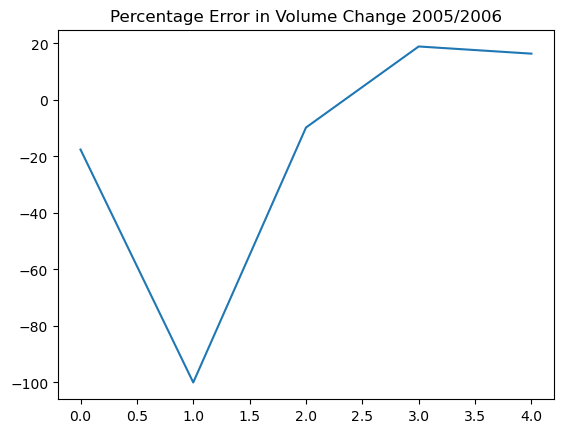

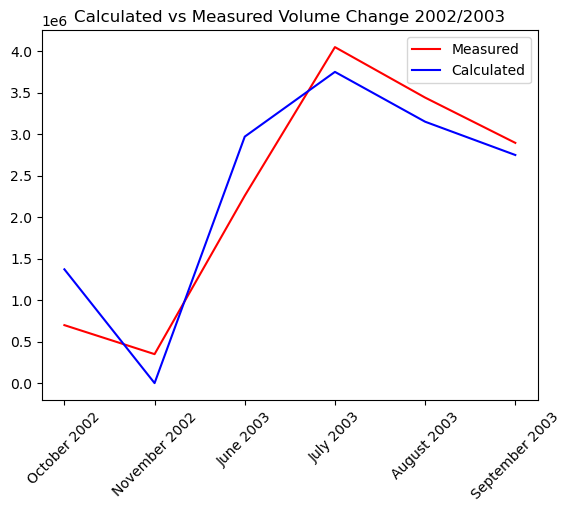

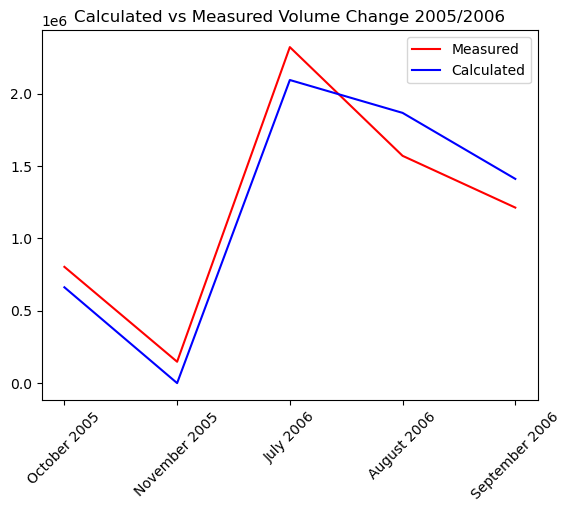

Relative Error 2002/2003:  7.047789211251473
Relative Error 2005/2006:  -92.11264543518652
Measured:  [ 699774  350110 2260774 4052802 3444012 2898108]
Calculated:  [1.37304761e+06 6.63197601e+02 2.97323702e+06 3.75402704e+06
 3.15315004e+06 2.75171690e+06]


In [93]:
# plt.plot(model.area_list, label='Measured')
# plt.plot(model.year_area_list, label='Calculated')
# plt.legend()
# plt.show()
plt.plot((model.calculated_winter_mb-model.winter_mb)/model.winter_mb*100)
plt.title("Percentage Error in Winter Mass Balance Verification")
plt.show()
plt.plot(model.winter_mb, c='r', label="Measured")
plt.plot(model.calculated_winter_mb, c='b', label="Calculated")
plt.legend()
plt.title("Calculated vs measured winter mass balance")
plt.show()
print(np.sum((model.calculated_winter_mb-model.winter_mb)/model.winter_mb*100))
print("Measured: ",model.winter_mb)
print("Calculated: ",model.calculated_winter_mb)
plt.plot((model.calculated_summer_mb-model.summer_mb)/model.summer_mb*100)
plt.title("Percentage Error in Summer Mass Balance Verification")
plt.show()
plt.plot(model.summer_mb, c='r', label="Measured")
plt.plot(model.calculated_summer_mb, c='b', label="Calculated")
plt.legend()
plt.title("Calculated vs measured summer mass balance")
plt.show()
print(np.sum((model.calculated_summer_mb-model.summer_mb)/model.summer_mb*100))
print(model.summer_mb)
print(model.calculated_summer_mb)
# print(monthly_volume_change)
# plt.plot((model.thickness_change-model.thickness_change_verif) /np.abs(model.thickness_change_verif) * 100)
# plt.title("Percentage Error in Thickness Change Verification")
# plt.show()
# print(model.thickness_change)
# print(model.thickness_change_verif)
# plt.plot((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100)
# plt.title("Percentage Error in Front Variation Calculation")
# plt.show()
# print(model.front_variation_calc)
# print(model.front_variation_verif)
# plt.plot(model.ice_1986 - model.thickness_1986_verif[~np.isnan(model.thickness_1986_verif)]/model.thickness_1986_verif[~np.isnan(model.thickness_1986_verif)] * 100)
# plt.title("Percentage Error in Ice Thickness (1986 Verification)")
# plt.show()
# plt.plot((model.ela_list-model.ela_verif)/np.abs(model.ela_verif)*100)
# plt.title("Percentage Error in ELA")
# plt.show()
# print(model.ela_list)
# print(model.ela_verif)
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_2002_2003.keys())),'volume_change': model.daily_runoff_2002_2003})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change_2002_2003 = df.groupby('date')['volume_change'].sum().to_numpy()
month_year_labels_2002_2003 = df['date'].dt.strftime('%B %Y').unique()
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_2005_2006.keys())),'volume_change': model.daily_runoff_2005_2006})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change_2005_2006 = df.groupby('date')['volume_change'].sum().to_numpy()
month_year_labels_2005_2006 = df['date'].dt.strftime('%B %Y').unique()
plt.plot((monthly_volume_change_2002_2003-model.runoff_verif_2002_2003)/model.runoff_verif_2002_2003*100)
plt.title("Percentage Error in Volume Change 2002/2003")
plt.show()
plt.plot((monthly_volume_change_2005_2006-model.runoff_verif_2005_2006)/model.runoff_verif_2005_2006*100)
plt.title("Percentage Error in Volume Change 2005/2006")
plt.show()
plt.plot(model.runoff_verif_2002_2003, c='r', label="Measured")
plt.plot(monthly_volume_change_2002_2003, c='b', label="Calculated")
plt.title("Calculated vs Measured Volume Change 2002/2003")
plt.xticks(ticks=np.arange(len(month_year_labels_2002_2003)), labels=month_year_labels_2002_2003, rotation=45)
plt.legend()
plt.show()
plt.plot(model.runoff_verif_2005_2006, c='r', label="Measured")
plt.plot(monthly_volume_change_2005_2006, c='b', label="Calculated")
plt.title("Calculated vs Measured Volume Change 2005/2006")
plt.xticks(ticks=np.arange(len(month_year_labels_2005_2006)), labels=month_year_labels_2005_2006, rotation=45)
plt.legend()
plt.show()
print("Relative Error 2002/2003: ", np.sum((monthly_volume_change_2002_2003-model.runoff_verif_2002_2003)/model.runoff_verif_2002_2003)*100)
print("Relative Error 2005/2006: ", np.sum((monthly_volume_change_2005_2006-model.runoff_verif_2005_2006)/model.runoff_verif_2005_2006)*100)
print("Measured: ", model.runoff_verif_2002_2003)
print("Calculated: ", monthly_volume_change_2002_2003)

In [91]:
# df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Input_SouthCascade_Daily_Weather.csv')
# dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
# temps = df.iloc[:, 1].astype(float).to_numpy()
# precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
# df = pd.read_csv('C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', skiprows=25)
# annual_mb = df.iloc[:-1, 3].astype(float).tolist()
# summer_mb = df.iloc[:-1, 2].astype(float).tolist()
# winter_mb = df.iloc[:-1, 1].astype(float).tolist()
# lapse_rate=0.0065
# glac_temps=temps-lapse_rate*(1700-272)
# snow=precip[glac_temps<0]/1000
# #snow=precip/1000
# dates = [dates[i] for i in range(len(dates)) if glac_temps[i] < 0]
# snow_df = pd.DataFrame({'date': dates, 'snow': snow})
# snow_df = snow_df[snow_df['date'].dt.year != 2024]
# snow_year = snow_df.groupby(snow_df['date'].dt.year)['snow'].sum().to_numpy()
# print(snow_year)
# print(winter_mb)
# print(np.mean(np.array(winter_mb)/np.array(snow_year)))
# print(np.std(np.array(winter_mb)/np.array(snow_year)))
# plt.plot(snow_year*1.7, c='b')
# plt.plot(winter_mb, c='r')
# plt.show()
# plt.plot(np.array(winter_mb)/np.array(snow_year))
# plt.show()
# plt.plot(winter_mb, c='b')
# plt.plot(np.array(snow_year)*(np.mean(np.array(winter_mb)/np.array(snow_year))), c='r')
# plt.show()
# plt.plot((np.array(snow_year)*(np.mean(np.array(winter_mb)/np.array(snow_year)))-winter_mb)/winter_mb*100)


Plots the widths

In [92]:
# fig, ax = plt.subplots()
# _ = plt.close(fig) #used to prevent an empty plot from displaying
# # Initialize a line object
# line, = ax.plot([], [], 'b-')
# # Create a ScalarMappable for the color bar
# norm = plt.Normalize(vmin=0, vmax=np.max(model.ice_thickness_over_time))
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])

# # Add the color bar to the figure
# cbar = fig.colorbar(sm, ax=ax)
# # Define the update function
# def update(frame):
#     ax.clear()
#     ax.set_xlim(0,float(model.valley_length))
#     ax.set_ylim(-1000, 1000)
#     ax.set_aspect('equal', adjustable='datalim')
#     ax.set_ylabel("Width (m)")
#     ax.set_xlabel("Distance (m)")
#     if start_time==500: ax.set_title(f"Time: {frame + 1984}")
#     else: ax.set_title(f"Time: {frame + 1950}")
#     half_widths = model.widths_over_time[frame] / 2
#     ax.plot(model.x, half_widths, 'b-')  # Plot the positive half
#     ax.plot(model.x, -half_widths, 'b-')  # Plot the negative half
#     color = plt.cm.viridis(model.ice_thickness_over_time[frame] / np.max(model.ice_thickness_over_time))  # Normalize ice thickness for colormap
#     for i in range(len(model.x) - 1):
#         ax.fill_between(model.x[i:i+2], half_widths[i:i+2], -half_widths[i:i+2], color=color[i])
#     return line,
# #plt.plot((np.arange(0,model.time+model.save, model.save)), model.volume_change)
# # Create the animation
# anim2 = FuncAnimation(fig, update, frames=len(model.widths_over_time), blit=False, repeat=False)
# # Display the animation
# vid2 = HTML(anim2.to_jshtml())
# display(vid2)